In this notebook, the attacker uses the results from their measurement attempt (notebook 03) to forge a fake token which is passed to the bank. More details are found on section IV of 'Ensemble-Based Quantum-Token Protocol Benchmarked on IBM Quantum Processors' arXiv:2412.08530 (2024).

**Table of contents**<a id='toc0_'></a>    
- 1. [Solution Interval for zf](#toc1_)    
- 2. [Faker Reconstructs Token](#toc2_)    
- 3. [Experimental Results](#toc3_)    
  - 3.1. [Brisbane](#toc3_1_)    
    - 3.1.1. [Forged](#toc3_1_1_)    
  - 3.2. [Kyiv](#toc3_2_)    
  - 3.3. [Sherbrooke](#toc3_3_)    
  - 3.4. [Distributions](#toc3_4_)    
- 4. [Acceptance Probabilities](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/tex-gyre/texgyreheros-regular.otf'
fm.fontManager.addfont(font_path)
plt.rcParams.update({'font.size': 12, 'font.family': 'TeX Gyre Heros'})

from scipy.stats import norm, skewnorm
from scipy.integrate import quad
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Angle constants
z_b = np.linspace(-1, 1, 9)
phi_b = np.linspace(0, 2*np.pi, 9)
z_a = np.array([-1, -.9, -.5, 0, .5, .9, 1])

# number of qubits
nq = 300

# fitted contrasts
c_IBMQ = [0.9859975714946958, 0.9503942133692314, 0.8959943586043012, .843234615325578, .5630934365017465]

def na_analytical(theta_b, theta_a, phi_b, phi_a, c):
    """
    Analytical expression of the probability of the faker to measure the token in the |0> state, as defined in the paper.

    Parameters:
    z_b (float): The arccos of the angle of the RGate of the bank
    z_a (float): The arccos of the angle of the RGate of the faker
    phi_b (float): The phase of the RGate of the bank
    phi_a (float): The phase of the RGate of the faker
    n0 (float): The number of counts for the 0 state
    n1 (float): The number of counts for the 1 state

    Returns:
    float: The probability of the faker to measure the token in the |0> state
    """
    return 1/2 + c/2*(np.cos(theta_a)*np.cos(theta_b) + np.sin(theta_a)*np.sin(theta_b)*np.cos(phi_b - phi_a))

def calculate_angles_f(na, theta_a, phi_a, c):
    """
    Function for calculating the angles of the forged token based on the given parameters

    Parameters:
    na (float): fraction of qubits measured in the |0> state
    theta_a (float): polar angle of the measurement
    phi_a (float): azimuthal angle of the measurement
    c (float): contrast of the hardware

    Returns:
    float: The polar angle of the forged token
    float: The azimuthal angle of the forged token
    """

    alpha = (2*na-1)/c

    if theta_a == 0 or theta_a == np.pi:
        phi_f = np.random.uniform(0, 2*np.pi)
        if alpha/np.cos(theta_a) <-1:
            theta_f = np.pi
        elif alpha/np.cos(theta_a) > 1:
            theta_f = 0
        else:
            theta_f = np.arccos(alpha/np.cos(theta_a))

    else:
        delta = alpha**2*np.cos(theta_a)**2 - alpha**2 - np.cos(2*theta_a)/2 + 1/2

        if delta < 0:
            return np.random.uniform(0, np.pi), np.random.uniform(0, 2*np.pi)

        zf_max = alpha*np.cos(theta_a) + np.sqrt(delta)
        if zf_max > 1:
            theta_fmax = np.pi
        else:
            theta_fmax = np.arccos(zf_max)
                
        zf_min = alpha*np.cos(theta_a) - np.sqrt(delta)
        if zf_min < -1:
            theta_fmin = 0
        else:
            theta_fmin = np.arccos(zf_min)
        
        theta_f = np.random.uniform(theta_fmin, theta_fmax)

        arg = np.arccos((alpha - np.cos(theta_a)*np.cos(theta_f))/np.sin(theta_a)/np.sin(theta_f))
        phi_f = np.random.choice([phi_a - arg, phi_a + arg])

    return theta_f, phi_f

# 1. <a id='toc1_'></a>[Solution Interval for zf](#toc0_)

The solution interal of $z_f$ is given when the argument inside the arccos of Eq. 5 is smaller than 1 in module.

In [11]:
z_f = np.linspace(-1, 1, 100)
phi_f = np.linspace(0, 2*np.pi, 100)
n0 = 0.07838268172351492
n1 = 0.9216173182764851
c = n1 - n0
na = (.225 + .18)/2

alpha = (2*na-1)*(n0+n1)/(n1-n0)
delta = alpha**2*np.cos(np.arccos(-.5))**2 - alpha**2 - np.cos(2*np.arccos(-.5))/2 + 1/2

zf_max = alpha*-.5 + np.sqrt(delta)
zf_min = alpha*-.5 - np.sqrt(delta)

phi_f1 = np.pi/2 - np.arccos(alpha/np.sin(np.arccos(-.5))/np.sin(np.arccos(.3)) -1/np.tan(np.arccos(-.5))/np.tan(np.arccos(.3)) ) + 2*np.pi
phi_f2 = np.pi/2 + np.arccos(alpha/np.sin(np.arccos(-.5))/np.sin(np.arccos(.3)) -1/np.tan(np.arccos(-.5))/np.tan(np.arccos(.3)) )

<>:23: SyntaxWarning: invalid escape sequence '\p'
<>:23: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_74608/3449294916.py:23: SyntaxWarning: invalid escape sequence '\p'
  '$n_0=0.08$\n  \n $n_1=0.92$ \n \n $n_a=0.200 \pm 0.025$\n \n $z_a = -0.5$ \n\n $\phi_a = \pi/2$',va='center', ha='left')


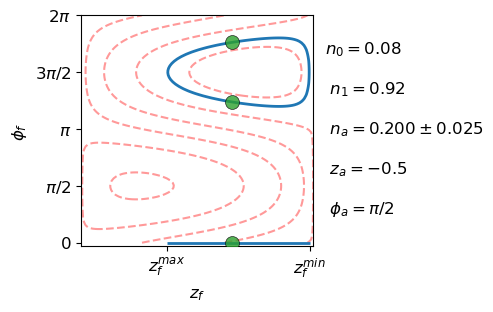

In [25]:
plt.figure(figsize=(3, 3))

plt.contour(z_f, phi_f, np.array([[na_analytical(np.arccos(a), np.arccos(-.5), b, np.pi/2, c) for a in z_f] for b in phi_f]).reshape(100,100), vmin=0, vmax=1, colors='r', alpha=.4, linestyles='dashed', levels=7)

min_value = .175
max_value = .225

mask = np.logical_and(np.array([[na_analytical(np.arccos(a), np.arccos(-.5), b, np.pi/2, c) for a in z_f] for b in phi_f]).reshape(100,100) >= min_value, 
                        np.array([[na_analytical(np.arccos(a), np.arccos(-.5), b, np.pi/2, c) for a in z_f] for b in phi_f]).reshape(100,100) <= max_value)

values_within_range = np.array([[na_analytical(np.arccos(a), np.arccos(-.5), b, np.pi/2, c) for a in z_f] for b in phi_f]).reshape(100,100)
values_within_range[~mask] = np.nan  # Set values outside the range to NaN

plt.contour(z_f, phi_f, values_within_range, vmin=min_value, vmax=max_value, levels=1, colors='C0', linewidths=2)

plt.xticks([zf_min, zf_max], [r'$z_f^{max}$', r'$z_f^{min}$'])
plt.yticks([0, np.pi/2, np.pi, np.pi*1.5, 2*np.pi], [r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
plt.hlines(0, zf_min, zf_max, lw=2, color='C0')

plt.scatter([.3, .3, .3], [0, phi_f1, phi_f2], c='C2', s=100, zorder=10, edgecolor='k', linewidth=.5, alpha=.8)

plt.text(1.1, np.pi, 
         '$n_0=0.08$\n  \n $n_1=0.92$ \n \n $n_a=0.200 \pm 0.025$\n \n $z_a = -0.5$ \n\n $\phi_a = \pi/2$',va='center', ha='left')

plt.ylim(-.1, 2*np.pi)
plt.xlabel(r'$z_f$')
plt.ylabel(r'$\phi_f$')
plt.savefig('./figures/zf_interval.pdf', bbox_inches='tight', transparent=True)

# 2. <a id='toc2_'></a>[Faker Reconstructs Token](#toc0_)

Given the $n_a$ measured values from the attacker attempt on reading the bank token, the forged token angles can be calculated.

In [5]:
# loads na results

na_brisbane_phi0 = np.empty(7, dtype=object)
na_brisbane_phi90 = np.empty(7, dtype=object)
na_kyiv = np.empty(7, dtype=object)
na_sherbrooke = np.empty(7, dtype=object)

for itr_za in range(len(z_a)):
    na_brisbane_phi0[itr_za] = np.loadtxt(f'./exp_data/brisbane/na_phi0/na_za_{z_a[itr_za]:.1f}.txt')
    na_brisbane_phi90[itr_za] = np.loadtxt(f'./exp_data/brisbane/na_phi90/na_za_{z_a[itr_za]:.1f}.txt')
    na_kyiv[itr_za] = np.loadtxt(f'./exp_data/kyiv/na/na_za_{z_a[itr_za]:.1f}.txt')
    na_sherbrooke[itr_za] = np.loadtxt(f'./exp_data/sherbrooke/na/na_za_{z_a[itr_za]:.1f}.txt')

# calculates the forged angles
forged_brisbane_phia0 = np.empty(7, dtype=object)
forged_brisbane_phia90 = np.empty(7, dtype=object)
forged_kyiv = np.empty(7, dtype=object)
forged_sherbrooke = np.empty(7, dtype=object)

for itr_za in range(len(z_a)):
    forged_brisbane_phia0[itr_za] = np.array([calculate_angles_f(na_brisbane_phi0[itr_za][itr]/300, np.arccos(z_a[itr_za]), 0, c_IBMQ[3]) for itr in range(81)])
    forged_brisbane_phia90[itr_za] = np.array([calculate_angles_f(na_brisbane_phi90[itr_za][itr]/300, np.arccos(z_a[itr_za]), np.pi/2, c_IBMQ[3]) for itr in range(81)])
    forged_kyiv[itr_za] = np.array([calculate_angles_f(na_kyiv[itr_za][itr]/300, np.arccos(z_a[itr_za]), 0, c_IBMQ[1]) for itr in range(81)])
    forged_sherbrooke[itr_za] = np.array([calculate_angles_f(na_sherbrooke[itr_za][itr]/300, np.arccos(z_a[itr_za]), 0, c_IBMQ[0]) for itr in range(81)])

In [ ]:
# save brisbane results
np.savetxt('./exp_data/brisbane/nf/angles_phia0.txt', np.c_[forged_brisbane_phia0[0], forged_brisbane_phia0[1], forged_brisbane_phia0[2], forged_brisbane_phia0[3], forged_brisbane_phia0[4], forged_brisbane_phia0[5], forged_brisbane_phia0[6]], delimiter='\t')
np.savetxt('./exp_data/brisbane/nf/angles_phia90.txt', np.c_[forged_brisbane_phia90[0], forged_brisbane_phia90[1], forged_brisbane_phia90[2], forged_brisbane_phia90[3], forged_brisbane_phia90[4], forged_brisbane_phia90[5], forged_brisbane_phia90[6]], delimiter='\t')

In [ ]:
# save kyiv results
np.savetxt('./exp_data/kyiv/nf/angles.txt', np.c_[forged_kyiv[0], forged_kyiv[1], forged_kyiv[2], forged_kyiv[3], forged_kyiv[4], forged_kyiv[5], forged_kyiv[6]], delimiter='\t')

In [ ]:
# save sherbrooke results
np.savetxt('./exp_data/sherbrooke/nf/angles.txt', np.c_[forged_sherbrooke[0], forged_sherbrooke[1], forged_sherbrooke[2], forged_sherbrooke[3], forged_sherbrooke[4], forged_sherbrooke[5], forged_sherbrooke[6]], delimiter='\t')

# 3. <a id='toc3_'></a>[Experimental Results](#toc0_)

The experimental results from the forgery attempt are loaded and the angle dependence is plotted for IBMQ Brisbane, Sherbrooke and Kyiv.

In [8]:
nf_brisbane_phi0 = np.empty(7, dtype=object)
nf_brisbane_phi90 = np.empty(7, dtype=object)
nf_kyiv = np.empty(7, dtype=object)
nf_sherbrooke = np.empty(7, dtype=object)

anglesf_kyiv = np.loadtxt('./exp_data/kyiv/nf/angles.txt')
anglesf_sherbrooke = np.loadtxt('./exp_data/sherbrooke/nf/angles.txt')
anglesf_phi0 = np.loadtxt('./exp_data/brisbane/nf/angles_phia0.txt')
anglesf_phi90 = np.loadtxt('./exp_data/brisbane/nf/angles_phia90.txt')

for itr_za in range(len(z_a)):
    nf_brisbane_phi0[itr_za] = np.loadtxt(f'./exp_data/brisbane/nf/nf_phi0/nf_za_{z_a[itr_za]:.1f}.txt')
    nf_brisbane_phi90[itr_za] = np.loadtxt(f'./exp_data/brisbane/nf/nf_phi90/nf_za_{z_a[itr_za]:.1f}.txt')
    nf_kyiv[itr_za] = np.loadtxt(f'./exp_data/kyiv/nf/nf_za_{z_a[itr_za]:.1f}.txt')
    nf_sherbrooke[itr_za] = np.loadtxt(f'./exp_data/sherbrooke/nf/nf_za_{z_a[itr_za]:.1f}.txt')
    
nf_brisbabe_combined = np.append([np.reshape(nf_brisbane_phi0[itr]/300, (9, 9)) for itr in range(7)], [np.reshape(nf_brisbane_phi90[itr]/300, (9, 9)) for itr in range(7)], axis=0)
nf_kyiv_combined = np.array(nf_kyiv.tolist())/300
nf_sherbrooke_combined = np.array(nf_sherbrooke.tolist())/300

## 3.1. <a id='toc3_1_'></a>[Brisbane](#toc0_)

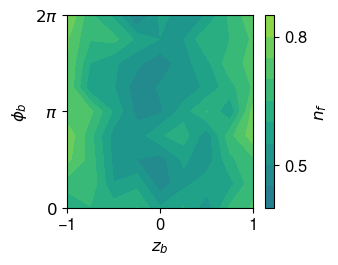

In [26]:
plt.figure(figsize=(3, 2.5))

plt.contourf(z_b, phi_b, np.mean(nf_brisbabe_combined, axis=0), cmap='viridis', vmin=0, vmax=1)
plt.xlabel(r'$z_b$')
plt.ylabel(r'$\phi_b$')
plt.yticks([0, np.pi, 2*np.pi], [r'$0$', r'$\pi$', r'$2\pi$'])
cbar = plt.colorbar(label=r'$n_f$', ticks=[.2, .5, .8])

## 3.2. <a id='toc3_2_'></a>[Kyiv](#toc0_)

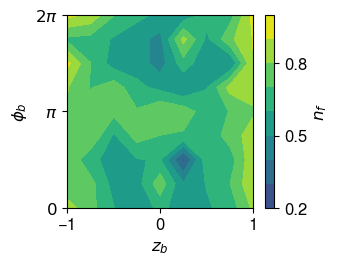

In [27]:
plt.figure(figsize=(3, 2.5))

plt.contourf(z_b, phi_b, np.mean(nf_kyiv/300, axis=0).reshape(9,9), cmap='viridis', vmin=0, vmax=1)
plt.xlabel(r'$z_b$')
plt.ylabel(r'$\phi_b$')
plt.yticks([0, np.pi, 2*np.pi], [r'$0$', r'$\pi$', r'$2\pi$'])
cbar = plt.colorbar(label=r'$n_f$', ticks=[.2, .5, .8])

## 3.3. <a id='toc3_3_'></a>[Sherbrooke](#toc0_)

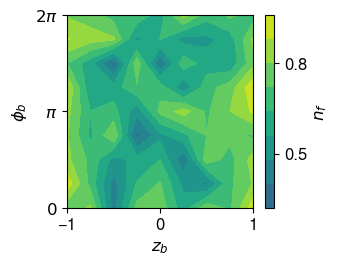

In [28]:
plt.figure(figsize=(3, 2.5))

plt.contourf(z_b, phi_b, np.mean(nf_sherbrooke/300, axis=0).reshape(9,9), cmap='viridis', vmin=0, vmax=1)
plt.xlabel(r'$z_b$')
plt.ylabel(r'$\phi_b$')
plt.yticks([0, np.pi, 2*np.pi], [r'$0$', r'$\pi$', r'$2\pi$'])
cbar = plt.colorbar(label=r'$n_f$', ticks=[.2, .5, .8])

## 3.4. <a id='toc3_4_'></a>[Distributions](#toc0_)

Distributions of $n_f$ compared to $n_b$. The danger of the bank token being cloned is proportional to the intersection between the two distributions.

In [7]:
# loads the nb distributions
nb_osaka = np.loadtxt('./exp_data/osaka/nb.txt')
nb_brisbane = np.loadtxt('./exp_data/brisbane/nb.txt')
nb_kyoto = np.loadtxt('./exp_data/kyoto/nb.txt')
nb_kyiv = np.loadtxt('./exp_data/kyiv/nb.txt')
nb_sherbrooke = np.loadtxt('./exp_data/sherbrooke/nb.txt')

# loads the nf distributions
nf_sim_brisbane = np.loadtxt('./sim_results/nf_average_brisbane.txt')
nf_sim_kyiv = np.loadtxt('./sim_results/nf_average_kyiv.txt')
nf_sim_sherbrooke = np.loadtxt('./sim_results/nf_average_sherbrooke.txt')

nf_sim = np.loadtxt('./sim_results/nf_average_c.txt')

theta_sim = np.linspace(1e-3, np.pi-1e-3, 100)
c_sim = np.arange(.1, 1.1, .1)

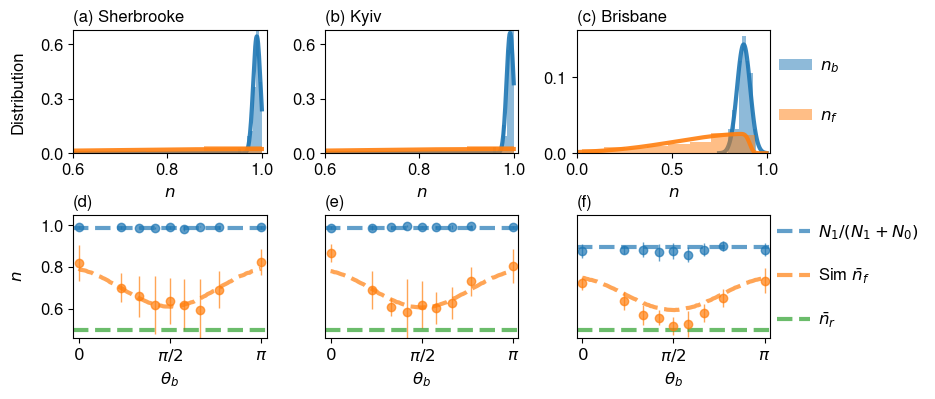

In [33]:
fig, axs = plt.subplots(2, 3, figsize=(9, 4))

axs[0][0].hist(nb_sherbrooke/nq, bins=8, alpha=.5, density=True)
axs[0][0].hist(nf_sherbrooke_combined.flatten(), bins=8, alpha=.5, density=True)

axs[0][1].hist(nb_kyiv/nq, bins=9, alpha=.5, density=True)
axs[0][1].hist(nf_kyiv_combined.flatten(), bins=10, alpha=.5, density=True)

axs[0][2].hist(nb_brisbane/nq, bins=8, alpha=.5, density=True, label=r'$n_b$')
axs[0][2].hist(nf_brisbabe_combined.flatten(), bins=8, alpha=.5, density=True, label=r'$n_f$')

x = np.linspace(0, 1, 1000)

axs[0][0].plot(x, norm.pdf(x, *norm.fit(nb_sherbrooke/nq)), alpha=.9, lw=3, c='C0', zorder=0)
axs[0][0].plot(x, skewnorm.pdf(x, *skewnorm.fit(nf_sherbrooke_combined.flatten())), alpha=.9, lw=3, c='C1')

axs[0][1].plot(x, norm.pdf(x, *norm.fit(nb_kyiv/nq)), alpha=.9, lw=3, c='C0', zorder=0)
axs[0][1].plot(x, skewnorm.pdf(x, *skewnorm.fit(nf_kyiv_combined.flatten())), alpha=.9, lw=3, c='C1')

axs[0][2].plot(np.linspace(0.75, 1, 100), norm.pdf(np.linspace(0.75, 1, 100), *norm.fit(nb_brisbane/nq)), alpha=.9, lw=3, c='C0', zorder=0)
axs[0][2].plot(x, skewnorm.pdf(x, *skewnorm.fit(nf_brisbabe_combined.flatten())), alpha=.9, lw=3, c='C1', zorder=1)

# axs[0][0].axvline(x=0.9859975714946958, linewidth=3, zorder=4, alpha=.8, linestyle='--')
# axs[0][1].axvline(x=0.9922633744855968, linewidth=3, zorder=4, alpha=.8, linestyle='--')
# axs[0][2].axvline(x=0.9216173182764851, linewidth=3, zorder=4, alpha=.8, linestyle='--')

axs[1][0].errorbar(np.arccos(z_b), np.mean(nb_sherbrooke.reshape(9,9), axis=0)/300,
                np.std(nb_sherbrooke.reshape(9,9), axis=0)/300, fmt='o', color='C0', linestyle='', lw=1, alpha=.7, markersize=6)
axs[1][1].errorbar(np.arccos(z_b), np.mean(nb_kyiv.reshape(9,9), axis=0)/300,
                np.std(nb_kyiv.reshape(9,9), axis=0)/300, fmt='o', color='C0', linestyle='', lw=1, alpha=.7, markersize=6)
axs[1][2].errorbar(np.arccos(z_b), np.mean(nb_brisbane.reshape(9,9), axis=0)/300, 
                np.std(nb_brisbane.reshape(9,9), axis=0)/300, fmt='o', color='C0', linestyle='', lw=1, alpha=.7, markersize=6)

axs[1][0].axhline(c_IBMQ[0], linestyle='--', color='C0', alpha=.7, lw=3)
axs[1][1].axhline(c_IBMQ[0], linestyle='--', color='C0', alpha=.7, lw=3)
axs[1][2].axhline(c_IBMQ[2], linestyle='--', color='C0', alpha=.7, lw=3, label=r'$ N_1/(N_1+N_0) $')

axs[1][0].plot(theta_sim, nf_sim_sherbrooke, color='C1', linestyle='--', lw=3, alpha=.7)
axs[1][1].plot(theta_sim, nf_sim_kyiv, color='C1', linestyle='--', lw=3, alpha=.7)
axs[1][2].plot(theta_sim, nf_sim_brisbane[0,:], color='C1', linestyle='--', lw=3, alpha=.7, label=r'Sim $ \bar{n}_f $')

axs[1][0].errorbar(np.arccos(z_b), np.mean(np.mean(nf_sherbrooke/300, axis=0).reshape(9,9), axis=0),
                np.std(np.mean(nf_sherbrooke/300, axis=0).reshape(9,9), axis=0), fmt='o', color='C1', linestyle='', lw=1, alpha=.7, zorder=2, markersize=6)

axs[1][1].errorbar(np.arccos(z_b), np.mean(np.mean(nf_kyiv/300, axis=0).reshape(9,9), axis=0),
             np.std(np.mean(nf_kyiv/300, axis=0).reshape(9,9), axis=0), fmt='o', color='C1', linestyle='', lw=1, alpha=.7, zorder=2, markersize=6)

axs[1][2].errorbar(np.arccos(z_b), np.mean(np.mean(nf_brisbabe_combined, axis=0), axis=0),
             np.std(np.mean(nf_brisbabe_combined, axis=0), axis=0), fmt='o', color='C1', linestyle='', lw=1, alpha=.7, zorder=2, markersize=6)

for itr in range(3):
    axs[1][itr].axhline(.5, linestyle='--', color='C2', alpha=.7, lw=3, label=r'$ \bar{n}_r $')
    axs[1][itr].set_ylim(0.46, 1.05)
    axs[1][itr].set_xlim(-.1, np.pi+.1)
    axs[1][itr].set_xticks([0, np.pi/2, np.pi], [r'$0$', r'$\pi/2$', r'$\pi$'])
    axs[1][itr].set_xlabel(r'$\theta_b$')
    axs[0][itr].set_xlabel(r'$n$')

axs[0][0].set_xlim(.6, 1.01)
axs[0][1].set_xlim(.6, 1.01)
axs[0][2].set_xlim(0, 1.02)
axs[0][2].set_xticks([0, .5, 1])

axs[0][1].set_ylim(0, 55)
axs[0][0].set_ylim(0, 55)

axs[1][1].set_yticks([])
axs[1][2].set_yticks([])

axs[0][0].set_title('(a) Sherbrooke', fontsize=12, loc='left')
axs[0][1].set_title('(b) Kyiv', fontsize=12, loc='left')
axs[0][2].set_title('(c) Brisbane', fontsize=12, loc='left')
axs[1][0].set_title('(d)', fontsize=12, loc='left')
axs[1][1].set_title('(e)', fontsize=12, loc='left')
axs[1][2].set_title('(f)', fontsize=12, loc='left')

axs[1][0].set_ylabel(r'$n$', labelpad=10)
axs[0][0].set_ylabel(r'Distribution', labelpad=10)
axs[0][0].set_yticks([0, .3*81, .6*81], ['0.0', '0.3', '0.6'])
axs[0][1].set_yticks([0, .3*81, .6*81], ['0.0', '0.3', '0.6'])
axs[0][2].set_yticks([0, .1*81], ['0.0', '0.1'])

axs[0][2].legend(frameon=False, loc='center', bbox_to_anchor=(1.2, .5), handletextpad=.5, labelspacing=2)
axs[1][2].legend(frameon=False, loc='center', bbox_to_anchor=(1.4, .5), handletextpad=.5, labelspacing=1.5)

fig.subplots_adjust(wspace=0.3, hspace=0.5)
fig.savefig('./figures/IBMQ_nf.pdf', bbox_inches='tight', dpi=300, transparent=True)

# 4. <a id='toc4_'></a>[Acceptance Probabilities](#toc0_)

From the previous distributions, the acceptance probabilities can be calculated by integrating above the acceptance threshold.

In [9]:
nT = np.arange(0, 1.0001, .0001)
M = np.arange(1, 8, 1)

# calculates the fitted parameters of the bank distributions
nb_exp_mean = [norm.fit(nb_sherbrooke/nq)[0], norm.fit(nb_kyiv/nq)[0], norm.fit(nb_osaka/nq)[0], norm.fit(nb_brisbane/nq)[0], norm.fit(nb_kyoto/nq)[0]]
nb_exp_dev = [norm.fit(nb_sherbrooke/nq)[1], norm.fit(nb_kyiv/nq)[1], norm.fit(nb_osaka/nq)[1], norm.fit(nb_brisbane/nq)[1], norm.fit(nb_kyoto/nq)[1]]

# fitted parameters of the forger distributions
nf_exp_mean = [np.mean(nf_sherbrooke_combined.flatten()), np.mean(nf_kyiv_combined.flatten()), 0, np.mean(nf_brisbabe_combined), 0]
nf_exp_dev = [skewnorm.std(*skewnorm.fit(nf_sherbrooke_combined.flatten())), skewnorm.std(*skewnorm.fit(nf_kyiv_combined.flatten())), 0, skewnorm.std(*skewnorm.fit(nf_brisbabe_combined.flatten())), 0]

skewnorm_params = [skewnorm.fit(nf_sherbrooke_combined.flatten()), skewnorm.fit(nf_kyiv_combined.flatten()), skewnorm.fit(nf_brisbabe_combined.flatten())]

acceptance_bank_brisbane= np.empty(len(nT), dtype=float)
acceptance_forger_brisbane = np.empty(len(nT), dtype=float)
acceptance_bank_kyiv = np.empty(len(nT), dtype=float)
acceptance_forger_kyiv = np.empty(len(nT), dtype=float)
acceptance_bank_sherbrooke = np.empty(len(nT), dtype=float)
acceptance_forger_sherbrooke = np.empty(len(nT), dtype=float)

# calculates the acceptance of the bank and forger distributions
acceptance_bank_brisbane_ref = quad(norm.pdf, 0, 1, args=(nb_exp_mean[3], nb_exp_dev[3]))[0]
acceptance_forger_brisbane_ref = quad(skewnorm.pdf, 0, 1, args=( skewnorm_params[2] ))[0]
acceptance_bank_kyiv_ref = quad(norm.pdf, 0, 1, args=( nb_exp_mean[1], nb_exp_dev[1] ))[0]
acceptance_forger_kyiv_ref = quad(skewnorm.pdf, 0, 1, args=( skewnorm_params[1] ))[0]
acceptance_bank_sherbrooke_ref = quad(norm.pdf, 0, 1, args=( nb_exp_mean[0], nb_exp_dev[0] ))[0]
acceptance_forger_sherbrooke_ref = quad(skewnorm.pdf, 0, 1, args=( skewnorm_params[0] ))[0]

for itr_nT in range(len(nT)):
    acceptance_bank_brisbane[itr_nT] = quad(norm.pdf, nT[itr_nT], 1, args=(nb_exp_mean[3], nb_exp_dev[3]))[0] / acceptance_bank_brisbane_ref
    acceptance_forger_brisbane[itr_nT] = quad(skewnorm.pdf, nT[itr_nT], 1, args=( skewnorm_params[2] ))[0] / acceptance_forger_brisbane_ref
    acceptance_bank_kyiv[itr_nT] = quad(norm.pdf, nT[itr_nT], 1, args=( nb_exp_mean[1], nb_exp_dev[1] ))[0] / acceptance_bank_kyiv_ref
    acceptance_forger_kyiv[itr_nT] = quad(skewnorm.pdf, nT[itr_nT], 1, args=( skewnorm_params[1] ))[0] / acceptance_forger_kyiv_ref
    acceptance_bank_sherbrooke[itr_nT] = quad(norm.pdf, nT[itr_nT], 1, args=( nb_exp_mean[0], nb_exp_dev[0] ))[0] / acceptance_bank_sherbrooke_ref
    acceptance_forger_sherbrooke[itr_nT] = quad(skewnorm.pdf, nT[itr_nT], 1, args=( skewnorm_params[0] ))[0] / acceptance_forger_sherbrooke_ref

# Forger acceptance for 99.9% Bank acceptance
print('Sherbrooke')
print('\tpf', acceptance_forger_sherbrooke[np.where(acceptance_bank_sherbrooke >= .999)[0][-1]])
print('\t<nf>', np.mean(nf_sherbrooke_combined))
print('Kyiv')
print('\tp1', acceptance_forger_kyiv[np.where(acceptance_bank_kyiv >= .999)[0][-1]])
print('\t<nf>', np.mean(nf_kyiv_combined))
print('Brisbane')
print('\tp1', acceptance_forger_brisbane[np.where(acceptance_bank_brisbane >= .999)[0][-1]])
print('\t<nf>', np.mean(nf_brisbabe_combined.flatten()))

Sherbrooke
	pf 0.06542826247609308
	<nf> 0.684944150499706
Kyiv
	p1 0.05949575688098535
	<nf> 0.6820105820105821
Brisbane
	p1 0.2853540446201491
	<nf> 0.6112198706643152


In [20]:
# Forger acceptance for 99% Bank acceptance
print('Sherbrooke')
print('\tp1', acceptance_forger_sherbrooke[np.where(acceptance_bank_sherbrooke >= .99)[0][-1]])
print('Kyiv')
print('\tp1', acceptance_forger_kyiv[np.where(acceptance_bank_kyiv >= .99)[0][-1]])
print('Brisbane')
print('\tp1', acceptance_forger_brisbane[np.where(acceptance_bank_brisbane >= .99)[0][-1]])

Sherbrooke
	p1 0.05463623706122785
Kyiv
	p1 0.04879698512311526
Brisbane
	p1 0.23258654394052897


In [21]:
# Forger acceptance for 99.99% Bank acceptance
print('Sherbrooke')
print('\tp1', acceptance_forger_sherbrooke[np.where(acceptance_bank_sherbrooke >= .9999)[0][-1]])
print('Kyiv')
print('\tp1', acceptance_forger_kyiv[np.where(acceptance_bank_kyiv >= .9999)[0][-1]])
print('Brisbane')
print('\tp1', acceptance_forger_brisbane[np.where(acceptance_bank_brisbane >= .9999)[0][-1]])

Sherbrooke
	p1 0.07450740944823545
Kyiv
	p1 0.06827638665662743
Brisbane
	p1 0.32774312391698385


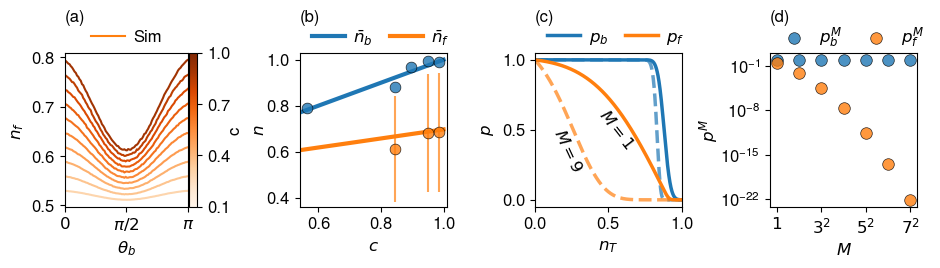

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(11,2))

############################

c_norm = Normalize(vmin=c_sim[0]-.3, vmax=c_sim[-1]+.15)
sm = ScalarMappable(norm=c_norm, cmap='Oranges')

for itr in range(len(c_sim)):
    color = sm.to_rgba(c_sim[itr])
    axs[0].plot(theta_sim, nf_sim[itr], alpha=1, lw=1.5, color=color)

axs[0].plot(0,0.6, color='C1', lw=1.5, label='Sim')
axs[0].set_xlabel(r'$\theta_b$')
axs[0].set_ylabel(r'$n_f$')
axs[0].set_xlim(0, np.pi)
axs[0].set_xticks([0, np.pi/2, np.pi], [r'$0$', r'$\pi/2$', r'$\pi$'])
axs[0].legend(frameon=False, loc='center', bbox_to_anchor=(.5, 1.1), handletextpad=.5, ncols=2, columnspacing=1)

cbar = plt.colorbar(sm, ax=axs[0], ticks=[.1,.4,.7, 1], pad=0.01)
cbar.set_label('c', labelpad=-2)
sm.set_clim(c_sim[0], c_sim[-1])

############################

axs[1].plot(c_sim, c_sim/2 +.5, label=r'$\bar{n}_b$', lw=3, color='C0')
axs[1].scatter(c_IBMQ, nb_exp_mean, c='C0', s=60, zorder=10, edgecolor='k', linewidth=.5, alpha=.8)
# axs[0].errorbar(c_IBMQ, nb_exp, yerr=nb_exp_dev, fmt='', color='black', linestyle='', lw=1.5, markersize=8, alpha=.7)

axs[1].scatter(c_IBMQ, nf_exp_mean, c='C1', s=60, zorder=10, edgecolor='k', linewidth=.5, alpha=.8)
axs[1].errorbar(c_IBMQ, nf_exp_mean, yerr=nf_exp_dev, fmt='', color='C1', linestyle='', lw=1.5, markersize=8, alpha=.7)

axs[1].plot(c_sim, np.mean(nf_sim, axis=1), lw=3, color='C1', label=r'$ \bar{n}_f $')
axs[1].set_ylim(0.36, 1.03)
axs[1].set_xlim(0.54, 1.01)
axs[1].set_yticks([.4, .6, .8, 1])
axs[1].set_xticks([.6, .8, 1])

axs[1].set_xlabel(r'$c$')
axs[1].set_ylabel(r'$n$', labelpad=-1)
axs[1].legend(frameon=False, loc='center', bbox_to_anchor=(.55, 1.1), handletextpad=.5, ncol=2, columnspacing=1)

##################################

axs[2].plot(nT, acceptance_bank_brisbane**9, c='C0', lw=2.5, linestyle='--', alpha=.7)
axs[2].plot(nT, acceptance_forger_brisbane**9, c='C1', lw=2.5, linestyle='--', alpha=.7)
axs[2].plot(nT, acceptance_bank_brisbane, c='C0', lw=2.5, label='$p_b$')
axs[2].plot(nT, acceptance_forger_brisbane, c='C1', lw=2.5, label='$p_f$')

axs[2].legend(frameon=False, loc='center', bbox_to_anchor=(.55, 1.1), handletextpad=.5, ncols=2, columnspacing=1)

axs[2].text(.55, .5, '$M=1$', va='center', ha='center', fontsize=12, rotation=-52)
axs[2].text(.22, .35, '$M=9$', va='center', ha='center', fontsize=12, rotation=-65)

axs[2].set_xlim(0, 1)
axs[2].set_ylim(-0.05, 1.05)
axs[2].set_xlabel(r'$n_T$')
axs[2].set_ylabel(r'$p$')
axs[2].set_yticks([0, .5, 1])
axs[2].set_xticks([.0, .5, 1])

##################################

axs[3].scatter(M,
               [acceptance_bank_brisbane[np.where(acceptance_bank_brisbane**(M**2) >= .999)[0][-1]]**(M**2) for M in M],
               s=70, zorder=10, edgecolor='k', linewidth=.5, alpha=.8, c='C0', label='$p_b^M$')
axs[3].scatter(M,
               [acceptance_forger_brisbane[np.where(acceptance_bank_brisbane**(M**2) >= .999)[0][-1]]**(M**2) for M in M],
               s=70, zorder=10, edgecolor='k', linewidth=.5, alpha=.8, c='C1', label='$p_f^M$')
axs[3].set_yscale('log')
axs[3].set_xticks([1, 3, 5, 7], [r'$1$', r'$3^2$', r'$5^2$',r'$7^2$'])
axs[3].set_xlabel(r'$M$')
axs[3].set_ylabel(r'$p ^{M}$', labelpad=0)
axs[3].set_yticks([1e-1, 1e-8, 1e-15, 1e-22])
axs[3].legend(frameon=False, loc='center', bbox_to_anchor=(.55, 1.1), handletextpad=.5, ncols=2, columnspacing=1)

##################################

axs[0].set_title('(a)', fontsize=12, loc='left', y=1.15)
axs[1].set_title('(b)', fontsize=12, loc='left', y=1.15)
axs[2].set_title('(c)', fontsize=12, loc='left', y=1.15)
axs[3].set_title('(d)', fontsize=12, loc='left', y=1.15)

fig.subplots_adjust(wspace=0.6)
fig.savefig('./figures/acceptance.pdf', bbox_inches='tight', transparent=True)

In [23]:
acceptance_forger_brisbane[np.where(acceptance_bank_brisbane**(49) >= .999)[0][-1]]**(49), acceptance_forger_kyiv[np.where(acceptance_bank_kyiv**(49) >= .999)[0][-1]]**(49), acceptance_forger_sherbrooke[np.where(acceptance_bank_sherbrooke**(49) >= .999)[0][-1]]**(49)

(np.float64(7.102087244043104e-23),
 np.float64(3.03392744328376e-56),
 np.float64(1.771304056486922e-54))